In [1]:
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import roc_auc_score, roc_curve

from project.scripts.preprocessing import *

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

In [2]:
train = pd.read_csv("/workspaces/ML-project-2025/data/train.csv")
test  = pd.read_csv("/workspaces/ML-project-2025/data/test.csv")

train['dataset'] = 'train'
test['dataset'] = 'test'

df = pd.concat([train, test], axis=0).reset_index(drop=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848563 entries, 0 to 848562
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    848563 non-null  int64  
 1   annual_income         848563 non-null  float64
 2   debt_to_income_ratio  848563 non-null  float64
 3   credit_score          848563 non-null  int64  
 4   loan_amount           848563 non-null  float64
 5   interest_rate         848563 non-null  float64
 6   gender                848563 non-null  object 
 7   marital_status        848563 non-null  object 
 8   education_level       848563 non-null  object 
 9   employment_status     848563 non-null  object 
 10  loan_purpose          848563 non-null  object 
 11  grade_subgrade        848563 non-null  object 
 12  loan_paid_back        593994 non-null  float64
 13  dataset               848563 non-null  object 
dtypes: float64(5), int64(2), object(7)
memory usage: 90.

In [4]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()

In [5]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
missing_df = missing_df[missing_df['Missing Values'] > 0]
print(missing_df.sort_values(by='Percentage', ascending=False))

                Missing Values  Percentage
loan_paid_back          254569   30.000012


# EDA

In [6]:
# plt.figure(figsize=(6, 4))
# # Use 'countplot' for categorical data
# sns.countplot(data=df, x='loan_paid_back', palette='Set2')

# plt.title('Distribution of Loan Payment Status', fontsize=14)
# plt.xlabel('Loan Paid Back', fontsize=12)
# plt.ylabel('Count', fontsize=12)
# plt.grid(axis='y', linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()

In [7]:
# Extract numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('id')  # Remove ID column if present

# Extract continuous columns (numerical columns with more than a threshold of unique values)
continuous_cols = [col for col in numerical_cols if df[col].nunique() > 10]

# Extract categorical columns
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()

# Print the results
print("Numerical Columns:", numerical_cols)
print("Continuous Columns:", continuous_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'loan_paid_back']
Continuous Columns: ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
Categorical Columns: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade', 'dataset']


In [8]:
# discrete_features = []

# # Loop through each numerical column
# for col in numerical_cols:
#     print(f"--- Visualizing: {col} ---")

#     # Set up a figure with two subplots side-by-side
#     fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#     fig.suptitle(f'Distribution of {col}', fontsize=16)

#     if col in continuous_cols:
#         # Left: Histogram for density/shape
#         sns.histplot(df[col].dropna(), kde=True, bins=30,
#                      ax=axes[0], color='skyblue', edgecolor='black')
#         axes[0].set_title('Histogram (Shape & Density)')
#         axes[0].set_xlabel(col)
#         axes[0].set_ylabel('Frequency')

#         # Right: Boxplot for quartiles/outliers
#         sns.boxplot(x=df[col].dropna(), ax=axes[1], color='lightcoral')
#         axes[1].set_title('Box Plot (Outliers & Spread)')
#         axes[1].set_xlabel(col)

#     elif col in discrete_features:
#         # Left: Count Plot for small integer-like features
#         sns.countplot(x=df[col].dropna(), ax=axes[0], palette='viridis', edgecolor='black')
#         axes[0].set_title('Count Plot (Frequency)')
#         axes[0].set_xlabel(col)
#         axes[0].set_ylabel('Count')

#         # Right: Boxplot (still useful)
#         sns.boxplot(x=df[col].dropna(), ax=axes[1], color='lightcoral')
#         axes[1].set_title('Box Plot (Summary)')
#         axes[1].set_xlabel(col)

#     plt.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.show()

#     # Print descriptive statistics
#     print("\n📊 Descriptive Statistics:")
#     print(df[col].describe().round(3))
#     print("\n" + "="*50 + "\n")

In [9]:
# for col in categorical_cols:
#     plt.figure(figsize=(8, 4))
#     sns.countplot(
#         data=df,
#         x=col,
#         order=df[col].value_counts().index,  # order bars by frequency
#         palette='Set2',
#         edgecolor='black'
#     )

#     plt.title(f'Distribution of {col}', fontsize=14)
#     plt.xlabel(col.replace('_', ' ').title(), fontsize=12)
#     plt.ylabel('Count', fontsize=12)

#     # Rotate labels if categories are long
#     plt.xticks(rotation=30, ha='right')
#     plt.grid(axis='y', linestyle='--', alpha=0.5)
#     plt.tight_layout()
#     plt.show()

#     # 🧮 Print Category Proportions
#     print(f'\n📊 Proportion of Each Category in "{col}":\n')
#     print(df[col].value_counts(normalize=True).round(3), '\n' + '-'*40)

In [10]:
# custom_palette = ['#E74C3C', '#27AE60']  # Red = Not Paid, Green = Paid

# target_col = 'loan_paid_back'  # Binary target variable (0 or 1)

# for col in categorical_cols:
#     plt.figure(figsize=(8, 5))
#     sns.countplot(
#         data=df,
#         x=col,
#         hue=target_col,
#         palette=custom_palette,
#         edgecolor='black',
#         order=df[col].value_counts().index  # Order bars by frequency
#     )
    
#     plt.title(f'{col.replace("_", " ").title()} by Loan Repayment Status', fontsize=14)
#     plt.xlabel(col.replace('_', ' ').title(), fontsize=12)
#     plt.ylabel('Count', fontsize=12)
#     plt.xticks(rotation=25, ha='right')
    
#     # Legend reflecting your target variable meaning
#     plt.legend(title='Loan Paid Back', labels=['No (0)', 'Yes (1)'])
#     plt.grid(axis='y', linestyle='--', alpha=0.4)
#     plt.tight_layout()
#     plt.show()

In [11]:
# plt.figure(figsize=(8, 6))
# sns.heatmap(df[['annual_income', 'debt_to_income_ratio', 'credit_score', 
#                 'loan_amount', 'interest_rate', 'loan_paid_back']].corr(),
#             annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('Correlation Heatmap (Numerical Features + Target)', fontsize=14)
# plt.show()

In [12]:
# def create_advanced_features(df):
#     df = df.copy()

#     # Core affordability
#     df['income_loan_ratio'] = df['annual_income'] / df['loan_amount'].replace(0, np.nan)
#     df['loan_to_income'] = df['loan_amount'] / df['annual_income'].replace(0, np.nan)
    
#     # Debt metrics
#     df['total_debt'] = df['debt_to_income_ratio'] * df['annual_income']
#     df['available_income'] = df['annual_income'] * (1 - df['debt_to_income_ratio'])
#     df['debt_burden'] = df['debt_to_income_ratio'] * df['loan_amount']
    
#     # Payment analysis (simple proxy)
#     df['monthly_payment'] = df['loan_amount'] * df['interest_rate'] / 1200
#     df['payment_to_income'] = df['monthly_payment'] / (df['annual_income'] / 12).replace(0, np.nan)
#     df['affordability'] = df['available_income'] / df['loan_amount'].replace(0, np.nan)
    
#     # Risk scoring
#     df['default_risk'] = (
#         df['debt_to_income_ratio'] * 0.40 + 
#         (850 - df['credit_score']) / 850 * 0.35 + 
#         df['interest_rate'] / 100 * 0.25
#     ).clip(0, 1)
    
#     # Credit analysis
#     df['credit_utilization'] = df['credit_score'] * (1 - df['debt_to_income_ratio'])
#     df['credit_interest_product'] = df['credit_score'] * df['interest_rate'] / 100
    
#     # Log transformations
#     for col in ['annual_income', 'loan_amount']:
#         df[f'{col}_log'] = np.log1p(df[col].clip(lower=0))
    
#     # Grade parsing
#     df['grade_letter'] = df['grade_subgrade'].astype(str).str[0]
#     df['grade_number'] = (
#         df['grade_subgrade'].astype(str).str[1:].str.extract(r'(\d+)')[0].astype('float')
#     )
#     grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
#     df['grade_rank'] = df['grade_letter'].map(grade_map).astype('float')
    
#     return df

In [13]:
NEW_FEATURES = [
    'income_loan_ratio', 'loan_to_income', 'total_debt', 
    'available_income', 'debt_burden', 'monthly_payment',
    'payment_to_income', 'affordability', 'default_risk',
    'credit_utilization', 'credit_interest_product',
    'annual_income_log', 'loan_amount_log', 'grade_letter',
    'grade_number', 'grade_rank'
]

print(f"Created {len(NEW_FEATURES)} new features")

df = create_advanced_features(df)

Created 16 new features


In [14]:
# Split into train/test sets
train_df = df[df["dataset"] == "train"].copy()
test_df = df[df["dataset"] == "test"].copy()

X_train = train_df.drop(["id", "loan_paid_back", "dataset"], axis=1)
y_train = train_df["loan_paid_back"]

X_test = test_df.drop(["id", "loan_paid_back", "dataset"], axis=1)

In [15]:
num_cols = [
    "annual_income",
    "debt_to_income_ratio",
    "credit_score",
    "loan_amount",
    "interest_rate"
]

cat_cols = [
    "gender",
    "marital_status",
    "education_level",
    "employment_status",
    "loan_purpose",
    "grade_subgrade"
]

# You can add binary flags (if any exist)
bool_cols = []  

# Columns to encode using Target Encoding (categorical + bools)
cols_to_encode = cat_cols + bool_cols

# ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("target_enc", TargetEncoder(cols=cols_to_encode, smoothing=25.0), cols_to_encode),
        ("scaler", StandardScaler(), num_cols)
    ],
    remainder="drop"
)

In [16]:
X_train.to_csv("X_train.csv", index=False)
y_train.to_csv("y_train.csv", index=False)

In [17]:
s = pd.read_csv("X_train.csv")

Accuracy:  0.9052
Precision: 0.9095
Recall:    0.9786
F1-score:  0.9428
ROC-AUC:   0.9217

MODEL PERFORMANCE SUMMARY (5-Fold CV)
         Accuracy  Precision  Recall      F1  ROC_AUC
XGBoost    0.9052     0.9095  0.9786  0.9428   0.9217


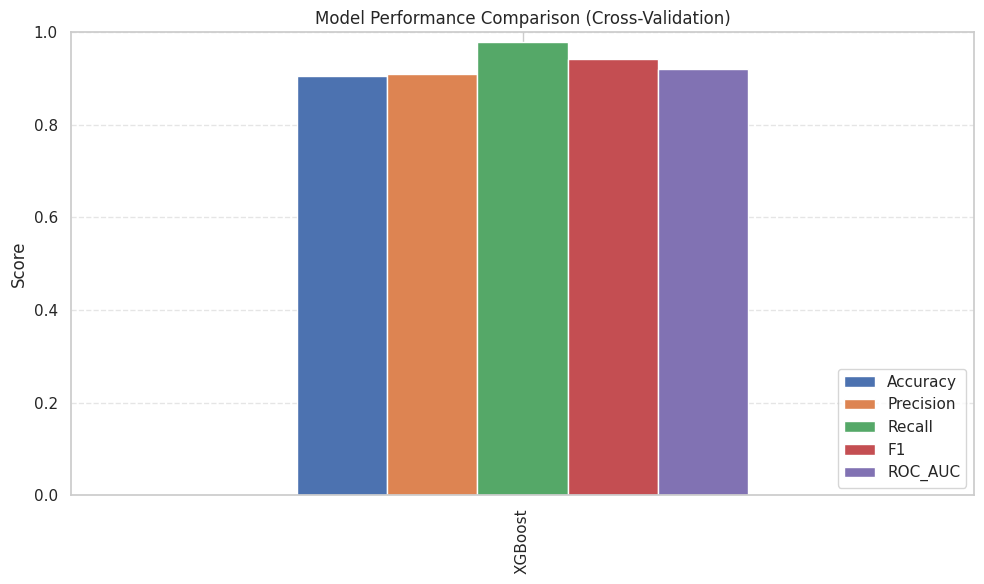

In [18]:
X = X_train
y = y_train

cv_results = {}

# Classification metrics
scoring = {
    "Accuracy": "accuracy",
    "Precision": "precision",
    "Recall": "recall",
    "F1": "f1",
    "ROC_AUC": "roc_auc"
}

# XGBoost Hyperparameters (Tuned for 80/20 Imbalance)
params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'random_state': 42,
    'n_jobs': -1,
    'tree_method': 'hist' # Faster training
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X))
scores = []

model = XGBClassifier(**params)
models = {"XGBoost":model}
for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    cv_scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=kf,
        scoring=scoring,
        n_jobs=-1
    )

    cv_results[name] = {metric: np.mean(scores) for metric, scores in cv_scores.items() if "test_" in metric}

    print(f"Accuracy:  {cv_results[name]['test_Accuracy']:.4f}")
    print(f"Precision: {cv_results[name]['test_Precision']:.4f}")
    print(f"Recall:    {cv_results[name]['test_Recall']:.4f}")
    print(f"F1-score:  {cv_results[name]['test_F1']:.4f}")
    print(f"ROC-AUC:   {cv_results[name]['test_ROC_AUC']:.4f}")

results_df = pd.DataFrame({
    model: {
        "Accuracy": cv_results[model]["test_Accuracy"],
        "Precision": cv_results[model]["test_Precision"],
        "Recall": cv_results[model]["test_Recall"],
        "F1": cv_results[model]["test_F1"],
        "ROC_AUC": cv_results[model]["test_ROC_AUC"]
    } for model in cv_results.keys()
}).T.round(4)

print("\n" + "=" * 80)
print("MODEL PERFORMANCE SUMMARY (5-Fold CV)")
print("=" * 80)
print(results_df)

# Optional: plot comparison
results_df.plot(kind='bar', figsize=(10,6))
plt.title('Model Performance Comparison (Cross-Validation)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()